# Import libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
import numpy as np
from scipy.stats import gaussian_kde
import os

sns.set_context("talk")

# Read in and clean mySAS data

In [2]:
#Set wd
os.chdir("..")

Es_file = 'mysasData/06122025/ES_LOG.txt'

# Explicit header that matches your logger columns
colnames = ["Time", "Sensor", "415", "445", "480", "515", "555", "590", "630", "680", "930", "Clear", "ASTEP", "ATIME", "GAIN", "Voltage"]

# Read the file without a header row, then assign proper column names
my_ES = pd.read_csv(Es_file, header=None, names=colnames)

# Check it worked
print(f"Rows before filtering: {len(my_ES)}")
my_ES.head()


Rows before filtering: 818


,Time,Sensor,415,445,480,515,555,590,630,680,930,Clear,ASTEP,ATIME,GAIN,Voltage
0,2025-06-11 14:17:14,Es,2583.0,3893.0,5645.0,7219.0,8714.0,10178.0,14003.0,14948.0,23977.0,58116.0,1000.0,255.0,5.0,1.06
1,2025-06-11 14:17:17,Es,2584.0,3893.0,5646.0,7221.0,8708.0,10170.0,13992.0,14936.0,23965.0,58075.0,1000.0,255.0,5.0,1.07
2,2025-06-11 14:17:19,Es,2584.0,3893.0,5646.0,7220.0,8712.0,10176.0,14001.0,14945.0,23984.0,58113.0,1000.0,255.0,5.0,1.08
3,2025-06-11 14:17:22,Es,2567.0,3868.0,5607.0,7170.0,8657.0,10110.0,13910.0,14848.0,23824.0,57738.0,1000.0,255.0,5.0,1.10
4,2025-06-11 14:17:24,Es,2582.0,3890.0,5640.0,7213.0,8710.0,10174.0,14000.0,14947.0,24009.0,58124.0,1000.0,255.0,5.0,1.06


## Convert Time

In [3]:
# Parse Time column, coerce bad entries to NaT
my_ES['Time'] = pd.to_datetime(my_ES['Time'], errors='coerce')

# Drop rows where Time is NaT (e.g., 'Error reading AS7341')
my_ES = my_ES.dropna(subset=['Time'])

# Correct actual deployment time (was mistakenly set to June 11)
actual_start = pd.Timestamp('2025-06-12 15:59:26')  # <-- updated date
simulated_start = my_ES['Time'].iloc[0]

# Compute and apply offset
time_offset = actual_start - simulated_start
my_ES['Time_UTC'] = my_ES['Time'] + time_offset
my_ES.head()

,Time,Sensor,415,445,480,515,555,590,630,680,930,Clear,ASTEP,ATIME,GAIN,Voltage,Time_UTC
0,2025-06-11 14:17:14,Es,2583.0,3893.0,5645.0,7219.0,8714.0,10178.0,14003.0,14948.0,23977.0,58116.0,1000.0,255.0,5.0,1.06,2025-06-12 15:59:26
1,2025-06-11 14:17:17,Es,2584.0,3893.0,5646.0,7221.0,8708.0,10170.0,13992.0,14936.0,23965.0,58075.0,1000.0,255.0,5.0,1.07,2025-06-12 15:59:29
2,2025-06-11 14:17:19,Es,2584.0,3893.0,5646.0,7220.0,8712.0,10176.0,14001.0,14945.0,23984.0,58113.0,1000.0,255.0,5.0,1.08,2025-06-12 15:59:31
3,2025-06-11 14:17:22,Es,2567.0,3868.0,5607.0,7170.0,8657.0,10110.0,13910.0,14848.0,23824.0,57738.0,1000.0,255.0,5.0,1.10,2025-06-12 15:59:34
4,2025-06-11 14:17:24,Es,2582.0,3890.0,5640.0,7213.0,8710.0,10174.0,14000.0,14947.0,24009.0,58124.0,1000.0,255.0,5.0,1.06,2025-06-12 15:59:36


## Convert counts for gain and integration

In [4]:
# Compute T_int in microseconds
my_ES['Tint_us'] = (my_ES['ATIME'] + 1) * my_ES['ASTEP'] * 2.78  # µs

# Map GAIN enum to multiplier
gain_enum_to_mult = {
    0: 0.5, 1: 1, 2: 2, 3: 4,
    4: 8, 5: 16, 6: 32, 7: 64,
    8: 128, 9: 256
}
my_ES['GAIN_MULT'] = my_ES['GAIN'].map(gain_enum_to_mult)

# Compute correction factor
my_ES['CORRECTION'] = my_ES['GAIN_MULT'] * my_ES['Tint_us']


In [5]:
# Define spectral channels
spectral_channels = ['415', '445', '480', '515', '555', '590', '630', '680']

# Apply correction to each spectral channel
corrected_data = my_ES[spectral_channels].div(my_ES['CORRECTION'], axis=0)

# Create new DataFrame with Time_UTC and corrected values
my_ES_corrected = pd.concat([my_ES['Time_UTC'], corrected_data], axis=1)

# Rename columns to indicate correction
my_ES_corrected.columns = ['Time_UTC'] + [f"{ch}_corr" for ch in spectral_channels]

## Remove first 2 min and last 2 min of data

In [6]:
# Define time range
start_time = my_ES_corrected['Time_UTC'].min()
end_time = my_ES_corrected['Time_UTC'].max()

cutoff_start = start_time + pd.Timedelta(minutes=2)
cutoff_end = end_time - pd.Timedelta(minutes=2)

# Trim to middle section
my_ES_trimmed = my_ES_corrected[
    (my_ES_corrected['Time_UTC'] > cutoff_start) &
    (my_ES_corrected['Time_UTC'] < cutoff_end)
].copy()
print(f"Remaining rows after filtering: {len(my_ES_trimmed)}")

Remaining rows after filtering: 585


## Remove any oversaturation

In [7]:
# Define spectral channels again
spectral_channels = ['415', '445', '480', '515', '555', '590', '630', '680']

# Find rows where any of the spectral bands hit saturation (65535)
saturated_mask = (my_ES[spectral_channels] >= 65535).any(axis=1)

# Apply the same time filter to get valid timestamps
valid_times = my_ES_trimmed['Time_UTC']

# Create a filtered version of the saturation mask for only the rows in my_ES_trimmed
saturated_times = my_ES.loc[saturated_mask, 'Time_UTC']

# Filter out saturated times
my_ES_cleaned = my_ES_trimmed[~my_ES_trimmed['Time_UTC'].isin(saturated_times)].copy()
my_ES_cleaned.head()

,Time_UTC,415_corr,445_corr,480_corr,515_corr,555_corr,590_corr,630_corr,680_corr
49,2025-06-12 16:01:29,0.000225,0.000339,0.000492,0.000629,0.000759,0.000887,0.001220,0.001303
50,2025-06-12 16:01:31,0.000226,0.000340,0.000492,0.000629,0.000759,0.000888,0.001221,0.001305
51,2025-06-12 16:01:34,0.000225,0.000339,0.000492,0.000629,0.000759,0.000887,0.001221,0.001304
52,2025-06-12 16:01:36,0.000226,0.000340,0.000492,0.000629,0.000760,0.000888,0.001222,0.001306
53,2025-06-12 16:01:39,0.000226,0.000340,0.000492,0.000629,0.000761,0.000889,0.001224,0.001307


In [8]:
print(f"Remaining rows after filtering: {len(my_ES_cleaned)}")

Remaining rows after filtering: 585


## Plot Logger Spectra

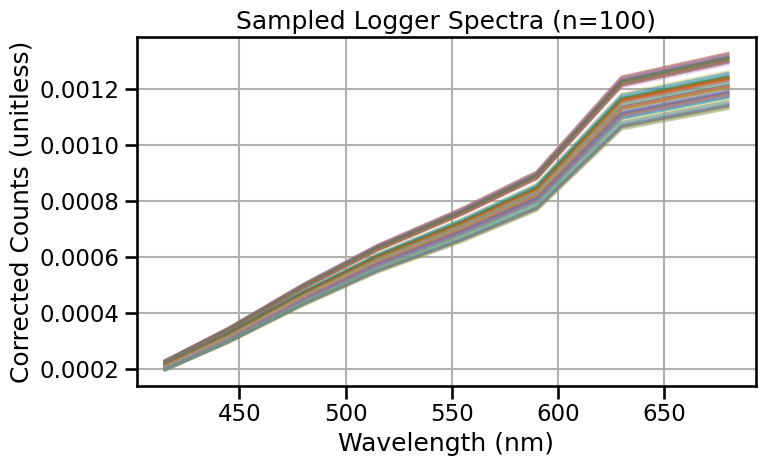

In [9]:
# Define wavelengths and column names
wavelengths = [415, 445, 480, 515, 555, 590, 630, 680]
corr_cols = [f"{wl}_corr" for wl in wavelengths]

# Select 100 random samples
subset = my_ES_cleaned.sample(n=100, random_state=42).reset_index(drop=True)

# Plot all spectra using the same color
plt.figure(figsize=(8, 5))
for _, row in subset.iterrows():
    plt.plot(wavelengths, row[corr_cols], alpha=0.3)

plt.xlabel("Wavelength (nm)")
plt.ylabel("Corrected Counts (unitless)")
plt.title("Sampled Logger Spectra (n=100)")
plt.grid(True)
plt.tight_layout()
plt.show()


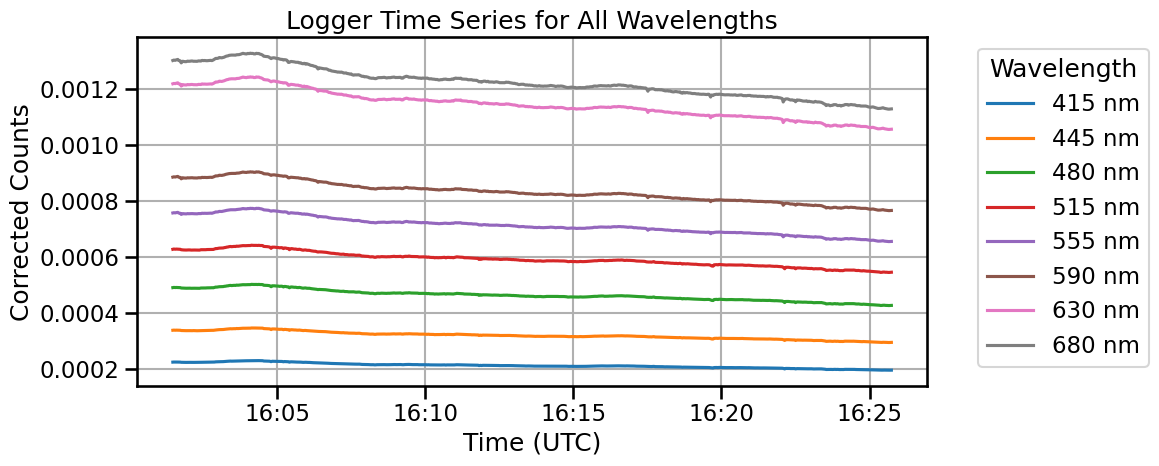

In [10]:
wavelengths = [415, 445, 480, 515, 555, 590, 630, 680]

plt.figure(figsize=(12, 5))

for wl in wavelengths:
    col = f"{wl}_corr"
    plt.plot(my_ES_cleaned['Time_UTC'], my_ES_cleaned[col], label=f'{wl} nm')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

plt.xlabel("Time (UTC)")
plt.ylabel("Corrected Counts")
plt.title("Logger Time Series for All Wavelengths")
plt.legend(title="Wavelength", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


# Read in pySAS data

In [47]:
Es_py_file = 'pysasData/Processed/L2/pySAS_Es_L2.csv'  # Adjust path as needed
py_ES = pd.read_csv(Es_py_file)
#py_ES.head()

Es_py_sd_file = 'pysasData/Processed/L2/pySAS_Es_sd_L2.csv'  # Adjust path as needed
py_sd_ES = pd.read_csv(Es_py_sd_file)
#py_sd_ES.head()

Es_py_unc_file = 'pysasData/Processed/L2/pySAS_Es_unc_L2.csv'  # Adjust path as needed
py_unc_ES = pd.read_csv(Es_py_unc_file)
#py_unc_ES.head()

Es_files = [py_ES, py_sd_ES, py_unc_ES]

## Convert time

In [48]:
def add_utc_timestamp(df):
    # Safely convert Datetag
    datetag_clean = df['Datetag'].astype(str).str.replace('.0', '', regex=False)
    year = datetag_clean.str[:4].astype(int)
    doy = datetag_clean.str[4:].astype(int)
    date_part = pd.to_datetime(year * 1000 + doy, format='%Y%j')

    # Parse Timetag2 as HHMMSSmmm
    timetag_str = df['Timetag2'].astype(int).astype(str).str.zfill(9)
    hours = timetag_str.str[0:2].astype(int)
    minutes = timetag_str.str[2:4].astype(int)
    seconds = timetag_str.str[4:6].astype(int)
    milliseconds = timetag_str.str[6:9].astype(int)

    # Combine date and time
    df['Time_UTC'] = date_part + \
        pd.to_timedelta(hours, unit='h') + \
        pd.to_timedelta(minutes, unit='m') + \
        pd.to_timedelta(seconds, unit='s') + \
        pd.to_timedelta(milliseconds, unit='ms')

    # Apply timezone shift from EDT to UTC
    df['Time_UTC'] -= pd.Timedelta(hours=4)
    return df

# Apply the function to all three files
Es_files = [add_utc_timestamp(df) for df in Es_files]

# Unpack back if needed
# py_ES, py_sd_ES, py_unc_ES = Es_files


In [49]:
# # Safely convert Datetag
# datetag_clean = py_ES['Datetag'].astype(str).str.replace('.0', '', regex=False)
# year = datetag_clean.str[:4].astype(int)
# doy = datetag_clean.str[4:].astype(int)
# date_part = pd.to_datetime(year * 1000 + doy, format='%Y%j')

# # Parse Timetag2 as HHMMSSmmm
# timetag_str = py_ES['Timetag2'].astype(int).astype(str).str.zfill(9)
# hours = timetag_str.str[0:2].astype(int)
# minutes = timetag_str.str[2:4].astype(int)
# seconds = timetag_str.str[4:6].astype(int)
# milliseconds = timetag_str.str[6:9].astype(int)

# # Combine date and time
# py_ES['Time_UTC'] = date_part + \
#     pd.to_timedelta(hours, unit='h') + \
#     pd.to_timedelta(minutes, unit='m') + \
#     pd.to_timedelta(seconds, unit='s') + \
#     pd.to_timedelta(milliseconds, unit='ms')

# # Apply timezone shift from EDT to UTC
# py_ES['Time_UTC'] -= pd.Timedelta(hours=4)
# py_ES.head()

In [50]:
# ---- 1. Mapping set-up (same as before) ----
logger_to_pysas = {
    '415': '416.0',
    '445': '445.7',
    '480': '478.7',
    '515': '515.0',
    '555': '554.6',
    '590': '590.9',
    '630': '630.5',
    '680': '680.0'
}

# ---- 2. Helper that extracts the visible bands and renames them ----
def subset_visible(df, mapping, suffix):
    """
    Return a DataFrame with Time_UTC and the eight visible bands,
    renamed <logger>_<suffix> so columns stay unique when you merge.
    """
    cols = ['Time_UTC'] + list(mapping.values())
    df_subset = df[cols].copy()

    rename_map = {'Time_UTC': 'Time_UTC'}
    rename_map.update({v: f"{k}_{suffix}" for k, v in mapping.items()})
    return df_subset.rename(columns=rename_map)

# ---- 3. Apply to each product ----
py_ES_visible      = subset_visible(py_ES, logger_to_pysas, 'pySAS')
py_sd_ES_visible   = subset_visible(py_sd_ES, logger_to_pysas, 'pySAS_sd')
py_unc_ES_visible  = subset_visible(py_unc_ES, logger_to_pysas, 'pySAS_unc')


In [51]:
py_ES_visible

,Time_UTC,415_pySAS,445_pySAS,480_pySAS,515_pySAS,555_pySAS,590_pySAS,630_pySAS,680_pySAS
0,2025-06-12 15:32:13.448,90.698094,109.093700,120.402869,112.137110,114.899908,108.057585,103.274350,98.821255
1,2025-06-12 15:37:16.182,86.385263,103.827272,114.621640,106.829588,109.566717,102.956712,98.681478,94.696429
2,2025-06-12 15:42:18.595,84.805449,102.032717,112.571357,104.953867,107.617636,101.117415,96.918040,93.021661
3,2025-06-12 15:47:16.620,82.499042,99.353191,109.753664,102.504845,105.265112,98.907958,94.998605,91.340904
4,2025-06-12 15:51:56.789,80.524470,97.134212,107.560657,100.599901,103.581965,97.413753,93.767857,90.495973
5,2025-06-12 15:57:20.189,81.731279,98.678924,109.292839,102.262894,105.198481,98.783120,95.028505,91.590112
6,2025-06-12 16:02:22.608,78.931985,95.463307,105.867339,99.170286,102.185704,96.051430,92.558324,89.459886
7,2025-06-12 16:07:18.360,78.122738,94.492368,104.701085,98.013673,100.845364,94.655669,91.106515,88.018403
8,2025-06-12 16:12:23.795,75.166178,90.812522,100.638622,94.205310,96.916722,90.963109,87.622707,84.734074
9,2025-06-12 16:17:24.995,72.891767,88.102469,97.496319,91.311411,93.793568,88.092071,84.687744,81.917186


In [52]:
py_sd_ES_visible

,Time_UTC,415_pySAS_sd,445_pySAS_sd,480_pySAS_sd,515_pySAS_sd,555_pySAS_sd,590_pySAS_sd,630_pySAS_sd,680_pySAS_sd
0,2025-06-12 15:32:13.448,0.000412,0.000372,0.000355,0.000358,0.000358,0.000374,0.000417,0.000458
1,2025-06-12 15:37:16.182,0.000216,0.000208,0.000198,0.000193,0.000180,0.000181,0.000161,0.000155
2,2025-06-12 15:42:18.595,0.000219,0.000211,0.000215,0.000202,0.000194,0.000195,0.000184,0.000185
3,2025-06-12 15:47:16.620,0.000282,0.000267,0.000266,0.000257,0.000250,0.000248,0.000236,0.000223
4,2025-06-12 15:51:56.789,0.000320,0.000326,0.000324,0.000314,0.000309,0.000313,0.000290,0.000278
5,2025-06-12 15:57:20.189,0.000313,0.000308,0.000305,0.000320,0.000301,0.000313,0.000295,0.000290
6,2025-06-12 16:02:22.608,0.000170,0.000152,0.000157,0.000160,0.000154,0.000160,0.000159,0.000155
7,2025-06-12 16:07:18.360,0.000169,0.000170,0.000164,0.000160,0.000162,0.000160,0.000172,0.000159
8,2025-06-12 16:12:23.795,0.000133,0.000107,0.000106,0.000115,0.000108,0.000122,0.000122,0.000136
9,2025-06-12 16:17:24.995,0.000137,0.000119,0.000126,0.000122,0.000118,0.000127,0.000131,0.000137


In [53]:
py_unc_ES_visible

,Time_UTC,415_pySAS_unc,445_pySAS_unc,480_pySAS_unc,515_pySAS_unc,555_pySAS_unc,590_pySAS_unc,630_pySAS_unc,680_pySAS_unc
0,2025-06-12 15:32:13.448,14.337385,18.714557,23.788767,30.199693,35.603786,37.216895,38.136111,44.682672
1,2025-06-12 15:37:16.182,14.039972,18.380396,23.399395,29.799987,35.197800,36.770542,37.780045,44.389491
2,2025-06-12 15:42:18.595,12.169255,15.901781,20.122625,25.413808,29.927400,31.195178,32.015960,37.515534
3,2025-06-12 15:47:16.620,13.484403,17.578928,22.278783,28.160776,33.184292,34.601903,35.592451,41.801104
4,2025-06-12 15:51:56.789,12.904158,16.940797,21.724154,27.927359,33.183957,34.759121,35.907353,42.563836
5,2025-06-12 15:57:20.189,11.096969,14.516463,18.465362,23.437176,27.687870,28.872919,29.761872,35.069438
6,2025-06-12 16:02:22.608,11.029785,14.471429,18.449046,23.492734,27.832588,29.062396,30.015598,35.491890
7,2025-06-12 16:07:18.360,11.008332,14.454322,18.418063,23.465205,27.773434,28.961341,29.874808,35.318052
8,2025-06-12 16:12:23.795,11.016101,14.445276,18.351720,23.251432,27.457538,28.591980,29.489193,34.810526
9,2025-06-12 16:17:24.995,10.288683,13.592254,17.405919,22.429595,26.599579,27.821086,28.701588,34.080433


In [54]:
# # Map logger wavelengths to nearest pySAS band available
# logger_to_pysas = {
#     '415': '416.0',
#     '445': '445.7',
#     '480': '478.7',
#     '515': '515.0',
#     '555': '554.6',
#     '590': '590.9',
#     '630': '630.5',
#     '680': '680.0'
# }

# # Create list of columns to extract
# pysas_columns = ['Time_UTC'] + list(logger_to_pysas.values())

# # Subset pySAS
# py_ES_visible = py_ES[pysas_columns].copy()

# # Rename columns to match logger names for easy comparison
# rename_columns = {'Time_UTC': 'Time_UTC'}
# rename_columns.update({v: f"{k}_pySAS" for k, v in logger_to_pysas.items()})
# py_ES_visible.rename(columns=rename_columns, inplace=True)

# # Preview
# py_ES_visible.head()


In [55]:
assert (py_ES_visible['Time_UTC'] == py_unc_ES_visible['Time_UTC']).all()


In [56]:
# ---- Step 1: Define columns and wavelengths ----
wavelengths = [415, 445, 480, 515, 555, 590, 630, 680]
pysas_cols = [f"{wl}_pySAS" for wl in wavelengths]
unc_cols = [f"{wl}_pySAS_unc" for wl in wavelengths]

# ---- Step 2: Merge visible and uncertainty dataframes ----
# Merge on index, keeping Time_UTC from just one source
merged = pd.concat([py_ES_visible, py_unc_ES_visible.drop(columns='Time_UTC')], axis=1)

# Quick check
#print(merged.shape)
merged


,Time_UTC,415_pySAS,445_pySAS,480_pySAS,515_pySAS,555_pySAS,590_pySAS,630_pySAS,680_pySAS,415_pySAS_unc,445_pySAS_unc,480_pySAS_unc,515_pySAS_unc,555_pySAS_unc,590_pySAS_unc,630_pySAS_unc,680_pySAS_unc
0,2025-06-12 15:32:13.448,90.698094,109.093700,120.402869,112.137110,114.899908,108.057585,103.274350,98.821255,14.337385,18.714557,23.788767,30.199693,35.603786,37.216895,38.136111,44.682672
1,2025-06-12 15:37:16.182,86.385263,103.827272,114.621640,106.829588,109.566717,102.956712,98.681478,94.696429,14.039972,18.380396,23.399395,29.799987,35.197800,36.770542,37.780045,44.389491
2,2025-06-12 15:42:18.595,84.805449,102.032717,112.571357,104.953867,107.617636,101.117415,96.918040,93.021661,12.169255,15.901781,20.122625,25.413808,29.927400,31.195178,32.015960,37.515534
3,2025-06-12 15:47:16.620,82.499042,99.353191,109.753664,102.504845,105.265112,98.907958,94.998605,91.340904,13.484403,17.578928,22.278783,28.160776,33.184292,34.601903,35.592451,41.801104
4,2025-06-12 15:51:56.789,80.524470,97.134212,107.560657,100.599901,103.581965,97.413753,93.767857,90.495973,12.904158,16.940797,21.724154,27.927359,33.183957,34.759121,35.907353,42.563836
5,2025-06-12 15:57:20.189,81.731279,98.678924,109.292839,102.262894,105.198481,98.783120,95.028505,91.590112,11.096969,14.516463,18.465362,23.437176,27.687870,28.872919,29.761872,35.069438
6,2025-06-12 16:02:22.608,78.931985,95.463307,105.867339,99.170286,102.185704,96.051430,92.558324,89.459886,11.029785,14.471429,18.449046,23.492734,27.832588,29.062396,30.015598,35.491890
7,2025-06-12 16:07:18.360,78.122738,94.492368,104.701085,98.013673,100.845364,94.655669,91.106515,88.018403,11.008332,14.454322,18.418063,23.465205,27.773434,28.961341,29.874808,35.318052
8,2025-06-12 16:12:23.795,75.166178,90.812522,100.638622,94.205310,96.916722,90.963109,87.622707,84.734074,11.016101,14.445276,18.351720,23.251432,27.457538,28.591980,29.489193,34.810526
9,2025-06-12 16:17:24.995,72.891767,88.102469,97.496319,91.311411,93.793568,88.092071,84.687744,81.917186,10.288683,13.592254,17.405919,22.429595,26.599579,27.821086,28.701588,34.080433


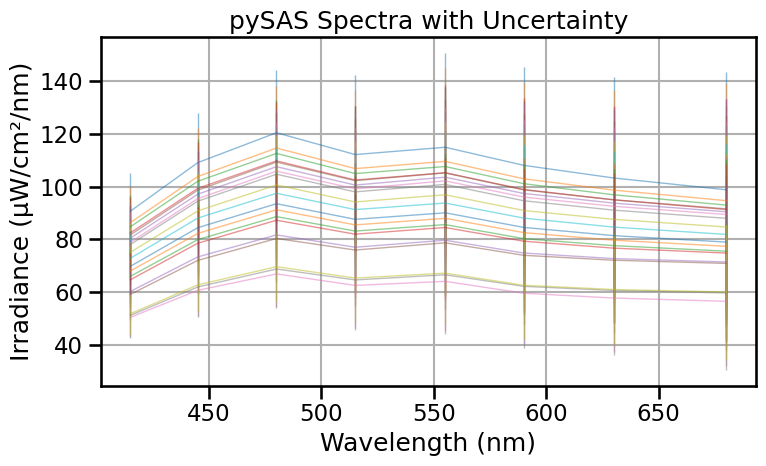

In [57]:
# ---- Step 4: Plot with uncertainty bars ----
plt.figure(figsize=(8, 5))
for _, row in merged.iterrows():
    y = row[pysas_cols].values
    yerr = row[unc_cols].values
    plt.errorbar(wavelengths, y, yerr=yerr, fmt='-', alpha=0.5, linewidth=1)

plt.xlabel("Wavelength (nm)")
plt.ylabel("Irradiance (µW/cm²/nm)")
plt.title("pySAS Spectra with Uncertainty")
plt.grid(True)
plt.tight_layout()
plt.show()


In [58]:
# # Define pySAS spectral columns and corresponding wavelengths
# pysas_cols = [f"{wl}_pySAS" for wl in [415, 445, 480, 515, 555, 590, 630, 680]]
# wavelengths = [415, 445, 480, 515, 555, 590, 630, 680]

# # Sample 100 rows
# subset_py = py_ES_visible.sample(n=100, random_state=42)

# # Plot spectra
# plt.figure(figsize=(8, 5))
# for _, row in subset_py.iterrows():
#     plt.plot(wavelengths, row[pysas_cols], alpha=0.3)

# plt.xlabel("Wavelength (nm)")
# plt.ylabel("Irradiance (µW/cm²/nm)")
# plt.title("Sampled pySAS Spectra (n=100)")
# plt.grid(True)
# plt.tight_layout()
# plt.show()


# Match mySAS to pySAS

## Match time

In [60]:
# Step 1: Start with your merged Es + unc dataframe
# (Assuming you called it 'merged' earlier)
merged['Time_UTC_trimmed'] = merged['Time_UTC'].dt.floor('s')

# Step 2: Trim to match the logger time range
start_time = my_ES_cleaned['Time_UTC'].min()
end_time = my_ES_cleaned['Time_UTC'].max()

merged_trimmed = merged[(merged['Time_UTC_trimmed'] >= start_time) &
                        (merged['Time_UTC_trimmed'] <= end_time)].copy()

print(f"Trimmed merged pySAS rows: {len(merged_trimmed)}")


Trimmed merged pySAS rows: 5


In [62]:
my_ES_cleaned['Time_UTC_trimmed'] = my_ES_cleaned['Time_UTC'].dt.floor('s')

# Final merge
final_df = pd.merge_asof(
    my_ES_cleaned.sort_values('Time_UTC_trimmed'),
    merged_trimmed.sort_values('Time_UTC_trimmed'),
    on='Time_UTC_trimmed',
    direction='nearest',
    tolerance=pd.Timedelta(seconds=1)
)
final_df.head()

,Time_UTC_x,415_corr,445_corr,480_corr,515_corr,555_corr,590_corr,630_corr,680_corr,Time_UTC_trimmed,...,630_pySAS,680_pySAS,415_pySAS_unc,445_pySAS_unc,480_pySAS_unc,515_pySAS_unc,555_pySAS_unc,590_pySAS_unc,630_pySAS_unc,680_pySAS_unc
0,2025-06-12 16:01:29,0.000225,0.000339,0.000492,0.000629,0.000759,0.000887,0.001220,0.001303,2025-06-12 16:01:29,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2025-06-12 16:01:31,0.000226,0.000340,0.000492,0.000629,0.000759,0.000888,0.001221,0.001305,2025-06-12 16:01:31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2025-06-12 16:01:34,0.000225,0.000339,0.000492,0.000629,0.000759,0.000887,0.001221,0.001304,2025-06-12 16:01:34,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2025-06-12 16:01:36,0.000226,0.000340,0.000492,0.000629,0.000760,0.000888,0.001222,0.001306,2025-06-12 16:01:36,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2025-06-12 16:01:39,0.000226,0.000340,0.000492,0.000629,0.000761,0.000889,0.001224,0.001307,2025-06-12 16:01:39,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [59]:
# # Round or floor pySAS timestamps to nearest second
# py_ES['Time_UTC_trimmed'] = py_ES['Time_UTC'].dt.floor('s')

# # Now subset using the trimmed column
# start_time = my_ES_cleaned['Time_UTC'].min()
# end_time = my_ES_cleaned['Time_UTC'].max()

# py_ES_trimmed = py_ES[(py_ES['Time_UTC_trimmed'] >= start_time) & (py_ES['Time_UTC_trimmed'] <= end_time)].copy()

# print(f"pySAS rows after time subsetting: {len(py_ES_trimmed)}")


pySAS rows after time subsetting: 5


## Match wavelengths

In [63]:
# Step 1: Define mapping
logger_to_pysas = {
    '415': '416.0',
    '445': '445.7',
    '480': '478.7',
    '515': '515.0',
    '555': '554.6',
    '590': '590.9',
    '630': '630.5',
    '680': '680.0'
}

# Step 2: Generate column lists
es_cols = [f"{v}" for v in logger_to_pysas.values()]
unc_cols = [f"{v}_pySAS_unc" for v in logger_to_pysas.values()]
all_cols = ['Time_UTC'] + es_cols + unc_cols

# Step 3: Subset and rename
pySAS_visible = merged_trimmed[all_cols].copy()

# Step 4: Rename columns to match logger naming
rename_map = {'Time_UTC': 'Time_UTC'}
rename_map.update({v: f"{k}_pySAS" for k, v in logger_to_pysas.items()})
rename_map.update({f"{v}_pySAS_unc": f"{k}_pySAS_unc" for k, v in logger_to_pysas.items()})

pySAS_visible.rename(columns=rename_map, inplace=True)

# Preview
pySAS_visible.head()


KeyError: "['416.0', '445.7', '478.7', '515.0', '554.6', '590.9', '630.5', '680.0', '416.0_pySAS_unc', '445.7_pySAS_unc', '478.7_pySAS_unc', '515.0_pySAS_unc', '554.6_pySAS_unc', '590.9_pySAS_unc', '630.5_pySAS_unc', '680.0_pySAS_unc'] not in index"

In [17]:
# # Map logger wavelengths to nearest pySAS band available
# logger_to_pysas = {
#     '415': '416.0',
#     '445': '445.7',
#     '480': '478.7',
#     '515': '515.0',
#     '555': '554.6',
#     '590': '590.9',
#     '630': '630.5',
#     '680': '680.0'
# }

# # Create list of columns to extract
# pysas_columns = ['Time_UTC'] + list(logger_to_pysas.values())

# # Subset pySAS
# py_ES_visible = py_ES_trimmed[pysas_columns].copy()

# # Rename columns to match logger names for easy comparison
# rename_columns = {'Time_UTC': 'Time_UTC'}
# rename_columns.update({v: f"{k}_pySAS" for k, v in logger_to_pysas.items()})
# py_ES_visible.rename(columns=rename_columns, inplace=True)

# # Preview
# py_ES_visible.head()


,Time_UTC,415_pySAS,445_pySAS,480_pySAS,515_pySAS,555_pySAS,590_pySAS,630_pySAS,680_pySAS
1056,2025-06-12 16:01:29.786,78.711991,95.156579,105.419244,98.807152,101.836327,95.779052,92.282314,89.210643
1057,2025-06-12 16:01:32.020,78.664166,95.138429,105.517156,98.901244,101.915520,95.779932,92.368143,89.343488
1058,2025-06-12 16:01:34.459,78.645033,95.232166,105.624214,98.943227,102.044057,96.021807,92.418236,89.311978
1059,2025-06-12 16:01:38.899,78.597699,95.053234,105.447925,98.806616,101.926930,95.800218,92.400090,89.383240
1060,2025-06-12 16:01:41.225,78.113140,94.749586,105.077745,98.391909,101.520858,95.440469,91.898400,89.134654


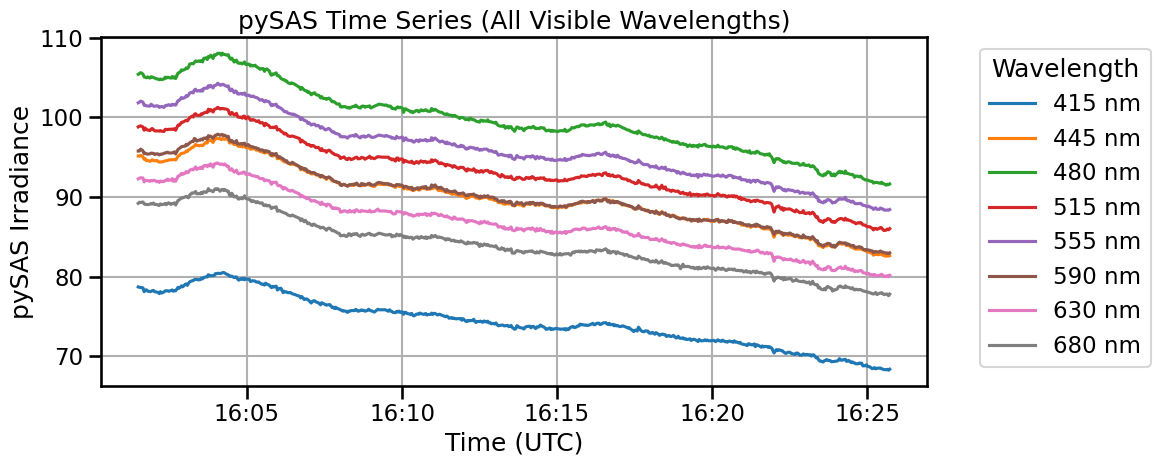

In [18]:
# Define wavelengths and column names
wavelengths = [415, 445, 480, 515, 555, 590, 630, 680]

plt.figure(figsize=(12, 5))
for wl in wavelengths:
    plt.plot(py_ES_visible['Time_UTC'], py_ES_visible[f'{wl}_pySAS'], label=f'{wl} nm')

# Format x-axis to show only HH:MM
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

plt.xlabel("Time (UTC)")
plt.ylabel("pySAS Irradiance")
plt.title("pySAS Time Series (All Visible Wavelengths)")
plt.legend(title="Wavelength", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


# Create Conversion factor

In [19]:
# Round both datasets' times to the nearest second
my_ES_cleaned['Time_UTC_rounded'] = my_ES_cleaned['Time_UTC'].dt.round('1s')
py_ES_visible['Time_UTC_rounded'] = py_ES_visible['Time_UTC'].dt.round('1s')

# Merge on the rounded timestamps
merged = pd.merge(
    my_ES_cleaned, py_ES_visible,
    on='Time_UTC_rounded', how='inner',
    suffixes=('_logger', '_pySAS')
)

# Check the merge result
merged.head()

,Time_UTC_logger,415_corr,445_corr,480_corr,515_corr,555_corr,590_corr,630_corr,680_corr,Time_UTC_rounded,Time_UTC_pySAS,415_pySAS,445_pySAS,480_pySAS,515_pySAS,555_pySAS,590_pySAS,630_pySAS,680_pySAS
0,2025-06-12 16:01:34,0.000225,0.000339,0.000492,0.000629,0.000759,0.000887,0.001221,0.001304,2025-06-12 16:01:34,2025-06-12 16:01:34.459,78.645033,95.232166,105.624214,98.943227,102.044057,96.021807,92.418236,89.311978
1,2025-06-12 16:01:39,0.000226,0.000340,0.000492,0.000629,0.000761,0.000889,0.001224,0.001307,2025-06-12 16:01:39,2025-06-12 16:01:38.899,78.597699,95.053234,105.447925,98.806616,101.926930,95.800218,92.400090,89.383240
2,2025-06-12 16:01:41,0.000226,0.000340,0.000492,0.000629,0.000758,0.000886,0.001220,0.001303,2025-06-12 16:01:41,2025-06-12 16:01:41.225,78.113140,94.749586,105.077745,98.391909,101.520858,95.440469,91.898400,89.134654
3,2025-06-12 16:01:46,0.000225,0.000338,0.000490,0.000627,0.000753,0.000880,0.001212,0.001295,2025-06-12 16:01:46,2025-06-12 16:01:45.607,78.350097,94.562330,104.981955,98.490009,101.472430,95.430521,92.105262,89.084062
4,2025-06-12 16:01:59,0.000225,0.000338,0.000490,0.000626,0.000756,0.000884,0.001217,0.001301,2025-06-12 16:01:59,2025-06-12 16:01:59.152,78.274534,94.586936,104.999638,98.480379,101.414977,95.478765,92.099028,89.249964


In [20]:
wavelengths = [415, 445, 480, 515, 555, 590, 630, 680]
regression_results = []

for wl in wavelengths:
    logger_col = f'{wl}_corr'
    pysas_col = f'{wl}_pySAS'

    # Drop NaNs
    valid = merged[[logger_col, pysas_col]].dropna()

    x = valid[logger_col].values.reshape(-1, 1)
    y = valid[pysas_col].values

    model = LinearRegression().fit(x, y)
    slope = model.coef_[0]
    intercept = model.intercept_
    r2 = model.score(x, y)

    # Calculate RMSE
    y_pred = model.predict(x)
    rmse = np.sqrt(np.mean((y - y_pred) ** 2))

    regression_results.append({
        'Wavelength': wl,
        'Slope': slope,
        'Intercept': intercept,
        'R²': r2,
        'RMSE': rmse
    })

    # Store predictions for plotting
    valid['pred'] = y_pred
    regression_results[-1]['data'] = valid


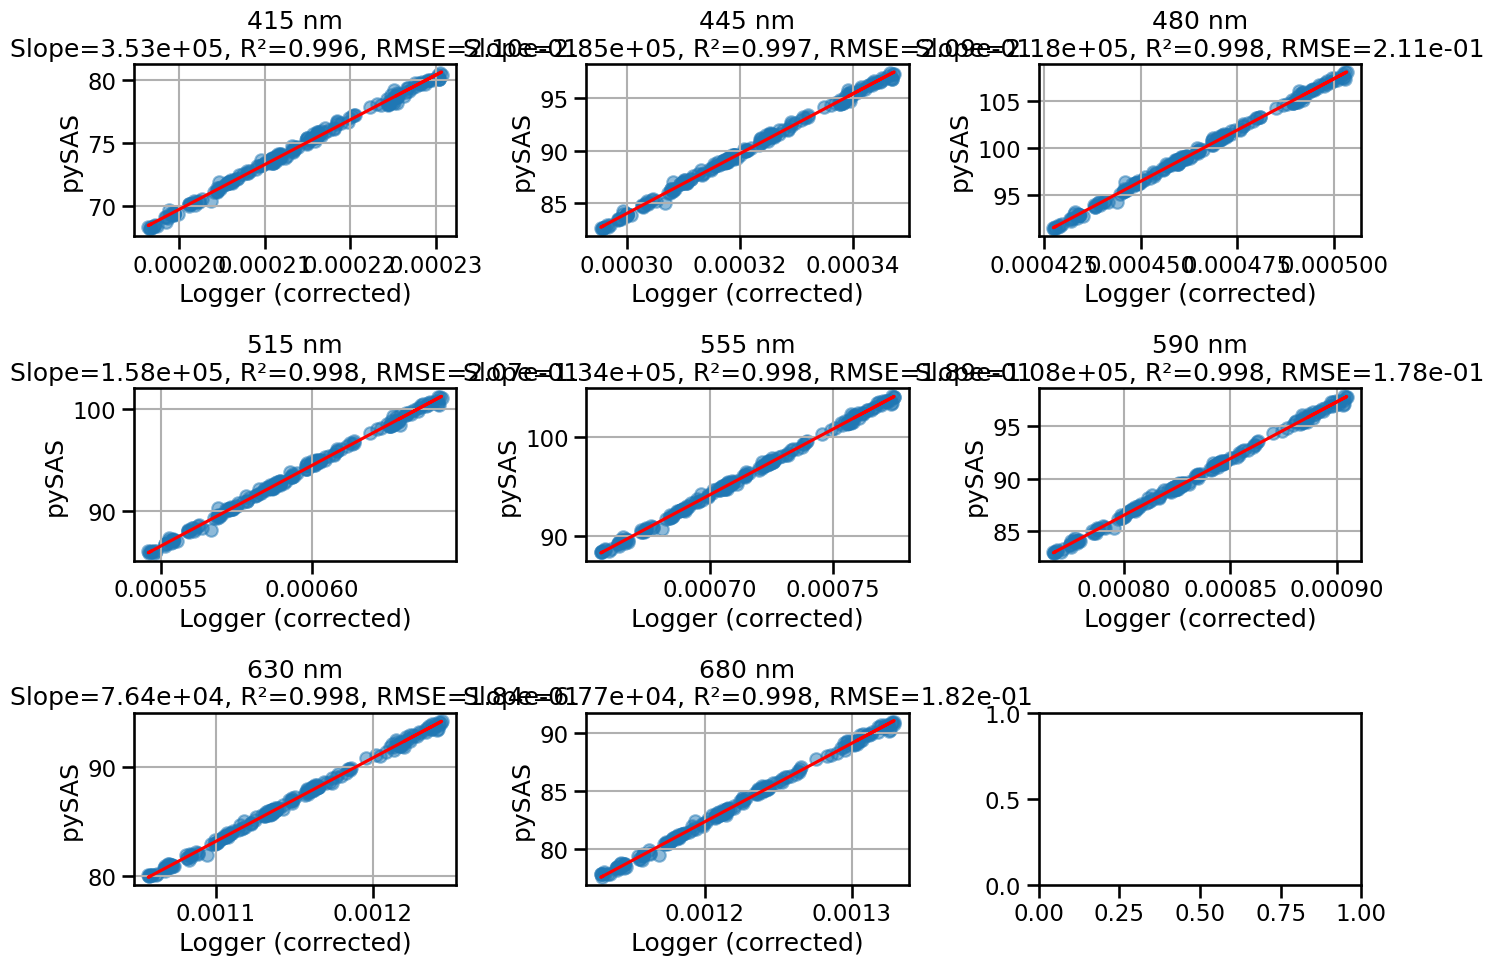

In [21]:
# Plot
fig, axes = plt.subplots(3, 3, figsize=(14, 10))
axes = axes.flatten()

for i, res in enumerate(regression_results):
    ax = axes[i]
    data = res['data']
    wl = res['Wavelength']

    ax.scatter(data[f'{wl}_corr'], data[f'{wl}_pySAS'], alpha=0.5, label='Data')
    ax.plot(data[f'{wl}_corr'], data['pred'], color='red', label='Fit')

    # Updated title to include RMSE
    ax.set_title(
        f"{wl} nm\nSlope={res['Slope']:.3g}, R²={res['R²']:.3f}, RMSE={res['RMSE']:.2e}"
    )

    ax.set_xlabel('Logger (corrected)')
    ax.set_ylabel('pySAS')
    ax.grid(True)

plt.tight_layout()
plt.show()


In [22]:
# Create summary DataFrame from regression results
summary_df = pd.DataFrame(regression_results).drop(columns='data')

# Display
print(summary_df.to_string(index=False))

# Export regression summary to CSV
summary_df.to_csv("Outputs/ES/mySAS_pySAS_Es_regression_summary.csv", index=False)


 Wavelength         Slope  Intercept       R²     RMSE
        415 352701.079607  -0.771043 0.996061 0.209775
        445 285096.510835  -1.524982 0.997355 0.209242
        480 217942.066577  -1.585658 0.997839 0.211144
        515 157986.969202  -0.367933 0.997627 0.207251
        555 134317.025318   0.111612 0.998188 0.189185
        590 108127.419210   0.006432 0.998184 0.178422
        630  76356.380040  -0.769275 0.997921 0.184154
        680  67743.353931   1.039793 0.997720 0.182300


# Apply Conversion Factor

In [23]:
my_ES_converted = pd.DataFrame()
my_ES_converted['Time_UTC'] = my_ES_cleaned['Time_UTC']

for _, row in summary_df.iterrows():
    wl = int(row['Wavelength'])  # Convert to integer
    slope = row['Slope']
    intercept = row['Intercept']

    input_col = f"{wl}_corr"
    output_col = f"{wl}_converted"

    my_ES_converted[output_col] = my_ES_cleaned[input_col] * slope + intercept


In [24]:
my_ES_converted['Time_UTC_rounded'] = my_ES_converted['Time_UTC'].dt.round('1s')
py_ES_visible['Time_UTC_rounded'] = py_ES_visible['Time_UTC'].dt.round('1s')


In [25]:
merged_converted = pd.merge(
    my_ES_converted, py_ES_visible,
    on='Time_UTC_rounded', how='inner', suffixes=('_logger', '_pySAS')
)


# Figures

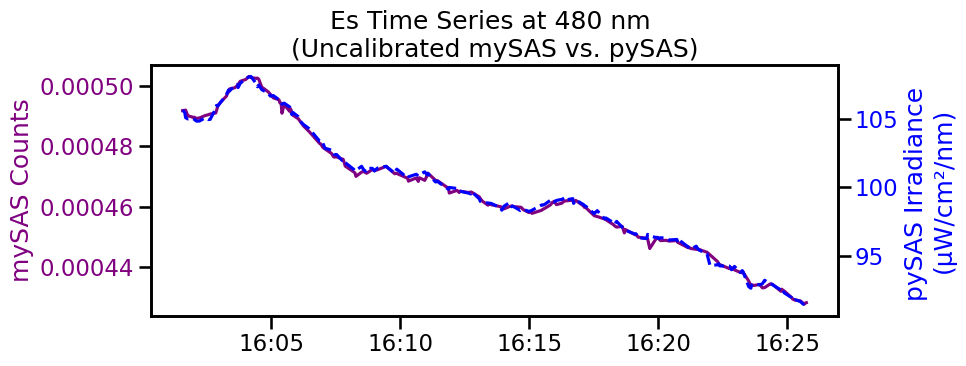

In [26]:
wl = 480  # Example wavelength

fig, ax1 = plt.subplots(figsize=(10, 4))

# Left axis: raw logger counts
ax1.plot(merged['Time_UTC_rounded'], merged[f'{wl}_corr'], color='purple', label='Logger (raw)')
ax1.set_ylabel('mySAS Counts', color='purple')
ax1.tick_params(axis='y', labelcolor='purple')
#ax1.set_xlabel('Time (UTC)')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# Right axis: pySAS irradiance
ax2 = ax1.twinx()
ax2.plot(merged['Time_UTC_rounded'], merged[f'{wl}_pySAS'], color='blue', linestyle='--', label='pySAS')
ax2.set_ylabel('pySAS Irradiance \n(µW/cm²/nm)', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

plt.title(f"Es Time Series at {wl} nm \n(Uncalibrated mySAS vs. pySAS)")
fig.tight_layout()
plt.savefig("Outputs/ES/mySAS_vs_pySAS_Es_TS_unCorr.png", dpi=300, bbox_inches='tight')
plt.show()


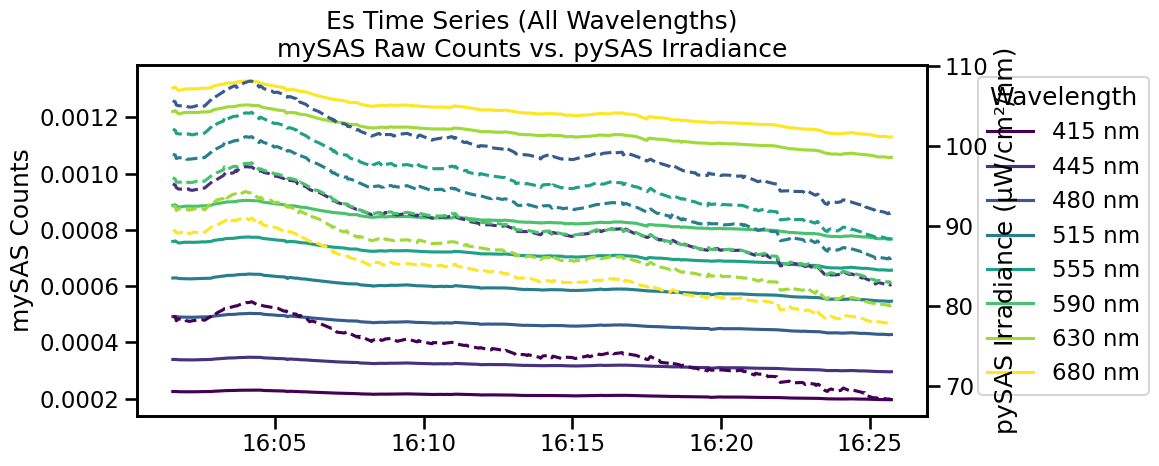

In [27]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cm as cm
import numpy as np

# Wavelengths to include
wavelengths = [415, 445, 480, 515, 555, 590, 630, 680]

# Generate a colormap for wavelength color coding
colors = cm.viridis(np.linspace(0, 1, len(wavelengths)))

# Create plot
fig, ax1 = plt.subplots(figsize=(12, 5))

# Plot raw mySAS counts (left y-axis)
for wl, color in zip(wavelengths, colors):
    ax1.plot(merged['Time_UTC_rounded'], merged[f'{wl}_corr'], color=color, label=f'{wl} nm (mySAS)')

ax1.set_ylabel('mySAS Counts', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# Add second y-axis for pySAS (right y-axis)
ax2 = ax1.twinx()

# Plot pySAS irradiance
for wl, color in zip(wavelengths, colors):
    ax2.plot(merged['Time_UTC_rounded'], merged[f'{wl}_pySAS'], linestyle='--', color=color, label=f'{wl} nm (pySAS)')

ax2.set_ylabel('pySAS Irradiance (µW/cm²/nm)', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Create custom legend (just one set of wavelengths)
handles = [plt.Line2D([0], [0], color=color, label=f"{wl} nm") for wl, color in zip(wavelengths, colors)]
ax1.legend(handles=handles, title='Wavelength', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title("Es Time Series (All Wavelengths)\nmySAS Raw Counts vs. pySAS Irradiance")
plt.xticks(rotation=45)
fig.tight_layout()
plt.savefig("Outputs/ES/mySAS_vs_pySAS_Es_TS_allWavelengths.png", dpi=300, bbox_inches='tight')
plt.show()


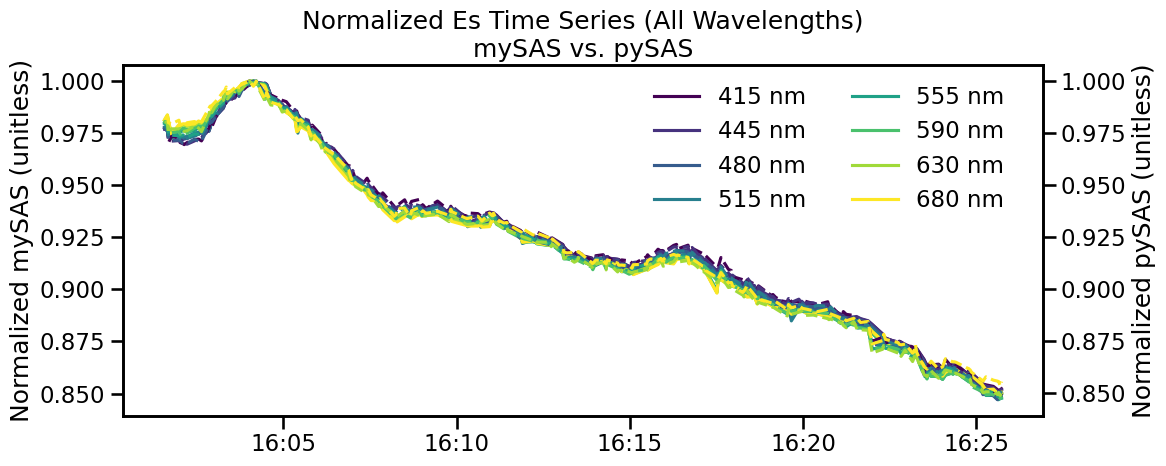

In [28]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cm as cm
import numpy as np

# Wavelengths to include
wavelengths = [415, 445, 480, 515, 555, 590, 630, 680]

# Generate a colormap for wavelength color coding
colors = cm.viridis(np.linspace(0, 1, len(wavelengths)))

# Create plot
fig, ax1 = plt.subplots(figsize=(12, 5))

# Plot normalized mySAS counts (left y-axis)
for wl, color in zip(wavelengths, colors):
    y_logger = merged[f'{wl}_corr'] / merged[f'{wl}_corr'].max()
    ax1.plot(merged['Time_UTC_rounded'], y_logger, color=color, label=f'{wl} nm (mySAS)')

ax1.set_ylabel('Normalized mySAS (unitless)', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# Add second y-axis for pySAS (right y-axis)
ax2 = ax1.twinx()
for wl, color in zip(wavelengths, colors):
    y_pysas = merged[f'{wl}_pySAS'] / merged[f'{wl}_pySAS'].max()
    ax2.plot(merged['Time_UTC_rounded'], y_pysas, linestyle='--', color=color, label=f'{wl} nm (pySAS)')

ax2.set_ylabel('Normalized pySAS (unitless)', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Create custom legend (one entry per wavelength)
# Create custom legend (one entry per wavelength)
handles = [plt.Line2D([0], [0], color=color, label=f"{wl} nm") for wl, color in zip(wavelengths, colors)]

# Place legend in upper right, inside plot, with 2 columns
ax1.legend(handles=handles, title='',
           loc='upper right', bbox_to_anchor=(0.98, 1),
           ncol=2, frameon=False)

plt.title("Normalized Es Time Series (All Wavelengths)\nmySAS vs. pySAS")
plt.xticks(rotation=45)

fig.tight_layout()
plt.savefig("Outputs/ES/mySAS_vs_pySAS_Es_TS_allWavelengths_normalized.png", dpi=300, bbox_inches='tight')
plt.show()


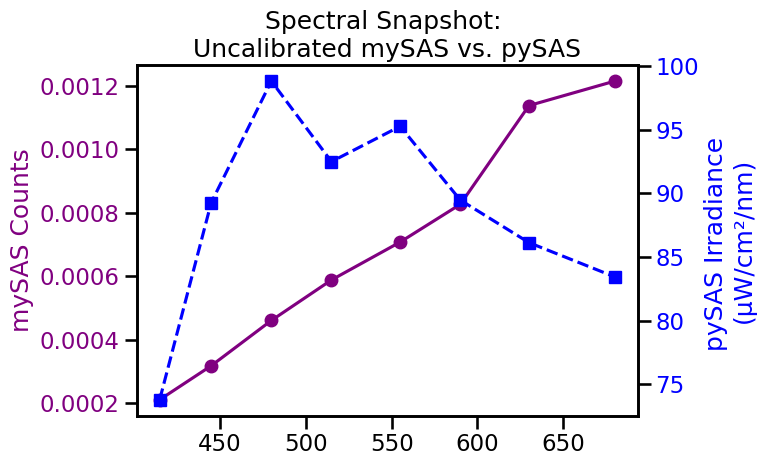

In [29]:
# Pick a representative row
row = merged.iloc[len(merged) // 2]

logger_vals = [row[f'{wl}_corr'] for wl in wavelengths]
pysas_vals  = [row[f'{wl}_pySAS'] for wl in wavelengths]

fig, ax1 = plt.subplots(figsize=(8, 5))

# Left y-axis: logger raw counts
ax1.plot(wavelengths, logger_vals, color='purple', marker='o')
ax1.set_ylabel("mySAS Counts", color='purple')
ax1.tick_params(axis='y', labelcolor='purple')

# Right y-axis: pySAS irradiance
ax2 = ax1.twinx()
ax2.plot(wavelengths, pysas_vals, color='blue', linestyle='--', marker='s')
ax2.set_ylabel("pySAS Irradiance \n(µW/cm²/nm)", color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

plt.xlabel("Wavelength (nm)")
plt.title("Spectral Snapshot: \nUncalibrated mySAS vs. pySAS")
fig.tight_layout()
plt.savefig("Outputs/ES/mySAS_vs_pySAS_Es_spectra_unCorr.png", dpi=300, bbox_inches='tight')
plt.show()


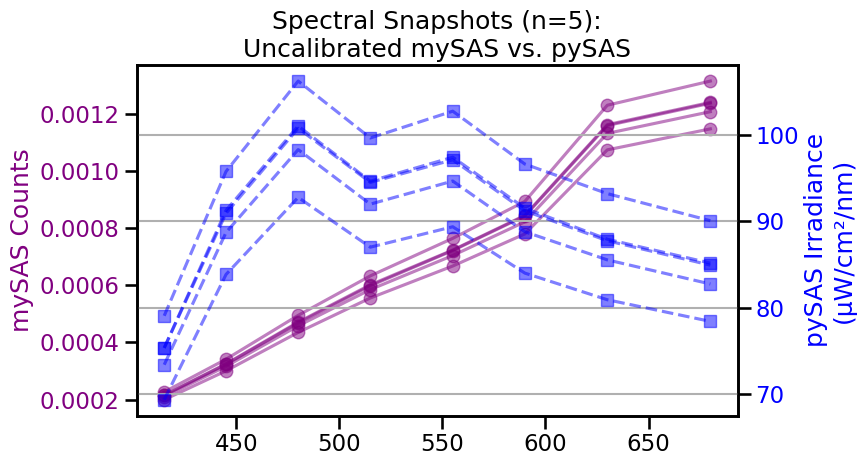

In [30]:
import matplotlib.pyplot as plt

# Pick 5 random snapshots from merged
subset = merged.sample(n=5, random_state=42)

fig, ax1 = plt.subplots(figsize=(9, 5))

# Plot raw mySAS counts (left y-axis)
for _, row in subset.iterrows():
    logger_vals = [row[f'{wl}_corr'] for wl in wavelengths]
    ax1.plot(wavelengths, logger_vals, color='purple', alpha=0.5, marker='o', linestyle='-')

ax1.set_ylabel("mySAS Counts", color='purple')
ax1.tick_params(axis='y', labelcolor='purple')

# Plot pySAS irradiance (right y-axis)
ax2 = ax1.twinx()
for _, row in subset.iterrows():
    pysas_vals = [row[f'{wl}_pySAS'] for wl in wavelengths]
    ax2.plot(wavelengths, pysas_vals, color='blue', alpha=0.5, marker='s', linestyle='--')

ax2.set_ylabel("pySAS Irradiance\n(µW/cm²/nm)", color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

plt.xlabel("Wavelength (nm)")
plt.title("Spectral Snapshots (n=5):\nUncalibrated mySAS vs. pySAS")
plt.grid(True)
fig.tight_layout()
plt.savefig("Outputs/ES/mySAS_vs_pySAS_Es_spectra_unCorr_multi.png", dpi=300, bbox_inches='tight')
plt.show()


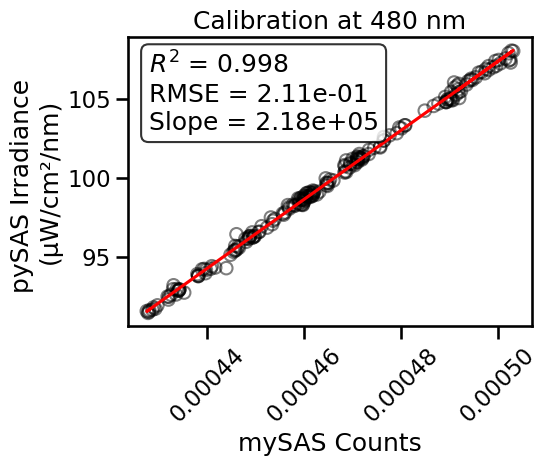

In [31]:
# Choose wavelength
wl = 480
x = merged[f'{wl}_corr'].values.reshape(-1, 1)
y = merged[f'{wl}_pySAS'].values

# Fit linear regression
model = LinearRegression().fit(x, y)
y_pred = model.predict(x)

slope = model.coef_[0]
intercept = model.intercept_
r2 = model.score(x, y)
rmse = np.sqrt(np.mean((y - y_pred) ** 2))

# Plot
plt.figure(figsize=(6, 5))
plt.scatter(x, y, alpha=0.5, label='Data', edgecolor='k', facecolor='none')
plt.plot(x, y_pred, color='red', label='Fit')

# Annotate stats
plt.title(f"Calibration at {wl} nm")
plt.xlabel("mySAS Counts")
plt.ylabel("pySAS Irradiance \n(µW/cm²/nm)")
plt.text(0.05, 0.95, f"$R^2$ = {r2:.3f}\nRMSE = {rmse:.2e}\nSlope = {slope:.3g}",
         transform=plt.gca().transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("Outputs/ES/mySAS_vs_pySAS_Es_regression.png", dpi=300, bbox_inches='tight')
plt.show()


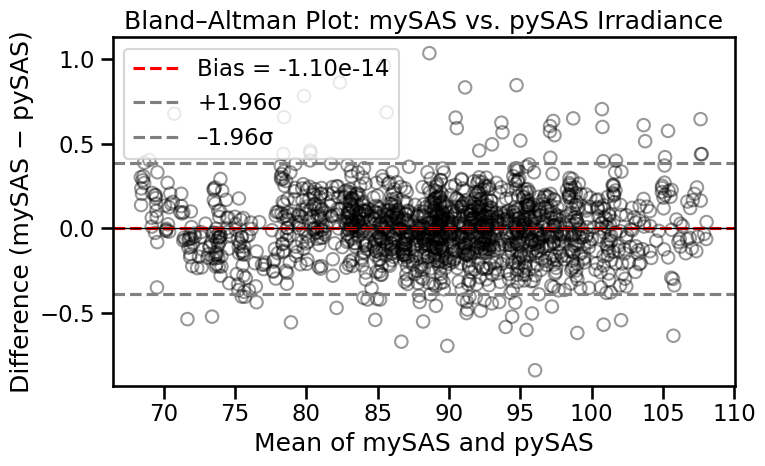

In [32]:
# Flatten all logger and pySAS values into single 1D arrays
logger_flat = merged_converted[[f'{wl}_converted' for wl in wavelengths]].to_numpy().flatten()
pysas_flat  = merged_converted[[f'{wl}_pySAS' for wl in wavelengths]].to_numpy().flatten()

# Mean and difference for each matched point
mean_vals = (logger_flat + pysas_flat) / 2
diff_vals = logger_flat - pysas_flat

# Compute bias and limits of agreement
bias = np.mean(diff_vals)
loa = 1.96 * np.std(diff_vals)

# Plot
plt.figure(figsize=(8, 5))
plt.scatter(mean_vals, diff_vals, alpha=0.4, edgecolor='k', facecolor='none')
plt.axhline(bias, color='red', linestyle='--', label=f'Bias = {bias:.2e}')
plt.axhline(bias + loa, color='gray', linestyle='--', label='+1.96σ')
plt.axhline(bias - loa, color='gray', linestyle='--', label='–1.96σ')
plt.axhline(0, color='black', linewidth=1)

plt.xlabel("Mean of mySAS and pySAS")
plt.ylabel("Difference (mySAS − pySAS)")
plt.title("Bland–Altman Plot: mySAS vs. pySAS Irradiance")
plt.legend()
plt.tight_layout()
plt.savefig("Outputs/ES/Bland_Altman_Es_regular.png", dpi=300, bbox_inches='tight')
plt.show()


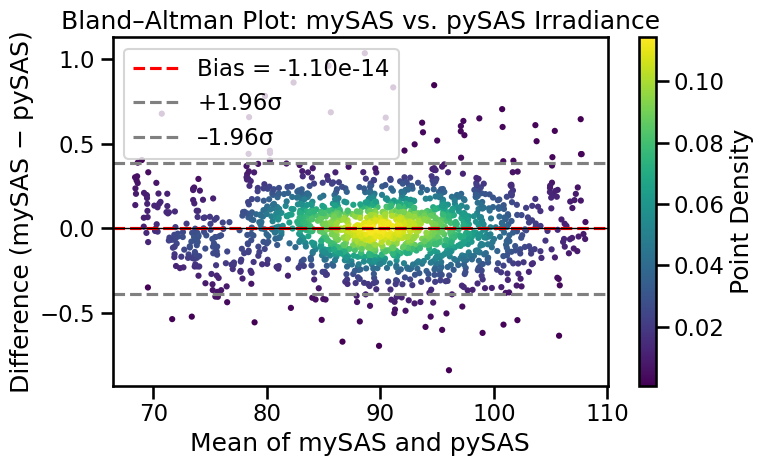

In [33]:
# Flatten all logger and pySAS values
logger_flat = merged_converted[[f'{wl}_converted' for wl in wavelengths]].to_numpy().flatten()
pysas_flat  = merged_converted[[f'{wl}_pySAS' for wl in wavelengths]].to_numpy().flatten()

# Mean and difference
mean_vals = (logger_flat + pysas_flat) / 2
diff_vals = logger_flat - pysas_flat

# Compute density
xy = np.vstack([mean_vals, diff_vals])
density = gaussian_kde(xy)(xy)

# Compute Bland–Altman stats
bias = np.mean(diff_vals)
loa = 1.96 * np.std(diff_vals)

# Plot
plt.figure(figsize=(8, 5))
sc = plt.scatter(mean_vals, diff_vals, c=density, cmap='viridis', s=20, edgecolor='none')
plt.axhline(bias, color='red', linestyle='--', label=f'Bias = {bias:.2e}')
plt.axhline(bias + loa, color='gray', linestyle='--', label='+1.96σ')
plt.axhline(bias - loa, color='gray', linestyle='--', label='–1.96σ')
plt.axhline(0, color='black', linewidth=1)

# Labels and style
plt.xlabel("Mean of mySAS and pySAS")
plt.ylabel("Difference (mySAS − pySAS)")
plt.title("Bland–Altman Plot: mySAS vs. pySAS Irradiance")
plt.colorbar(sc, label='Point Density')
plt.legend()
plt.tight_layout()

# Save and show
plt.savefig("Outputs/ES/Bland_Altman_Es_ptDensity.png", dpi=300, bbox_inches='tight')
plt.show()


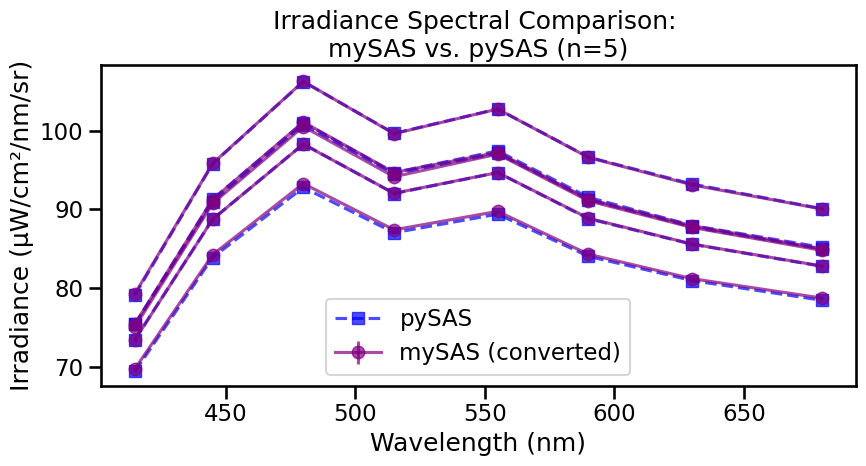

In [34]:
# Define wavelengths and column names
wavelengths = [415, 445, 480, 515, 555, 590, 630, 680]
logger_cols = [f'{wl}_converted' for wl in wavelengths]
pysas_cols  = [f'{wl}_pySAS' for wl in wavelengths]

# Get RMSE per wavelength from regression_results
rmse_map = {res['Wavelength']: res['RMSE'] for res in regression_results}
yerr = [rmse_map[wl] for wl in wavelengths]

# Sample 5 timepoints from the merged data
subset = merged_converted.sample(n=5, random_state=42)

# Plot
plt.figure(figsize=(9, 5))

for _, row in subset.iterrows():
    logger_vals = row[logger_cols].values
    pysas_vals  = row[pysas_cols].values

    # Logger with error bars
    plt.errorbar(wavelengths, logger_vals, yerr=yerr,
                 fmt='o-', color='purple', alpha=0.7, label='mySAS (converted)')

    # pySAS as dashed line
    plt.plot(wavelengths, pysas_vals, linestyle='--', marker='s',
             color='blue', alpha=0.7, label='pySAS')

# Avoid duplicate legend entries
handles, labels = plt.gca().get_legend_handles_labels()
unique = dict(zip(labels, handles))
plt.legend(unique.values(), unique.keys())

plt.xlabel("Wavelength (nm)")
plt.ylabel("Irradiance (µW/cm²/nm/sr)")
plt.title("Irradiance Spectral Comparison: \nmySAS vs. pySAS (n=5)")
plt.tight_layout()
plt.savefig("Outputs/ES/mySAS_vs_pySAS_Es_spectra.png", dpi=300, bbox_inches='tight')
plt.show()
